## Team 15 : Roselle Hsu(lifuh), Ryan Lu(ryanlu), Bochen Wang(bochenw)

# Phase 2 - Ingestion and Cleaning

In the Phase 2 of the Case Study, we will carry out the following steps:
  - Ingest raw downloaded data
  - Output a combined dataset ready for analysis and modeling

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Path to unzipped data: /content/drive/MyDrive/MLPS CASE/Archive/unzipped

Mounted at /content/drive


In [1]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn

In [2]:
# A helper function that you'll be using while reading the raw files
def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False

## Parameters

In [3]:
# Define the directories that contain the files downloaded
dir_cs = 'data/2003_download' # path to the directory where all the *.csv.zip files are located

# Define the output path for the pickle
pickle_file = "clean_data.pickle" # path to save cleaned data

In [4]:
# Identify the columns we'll be keeping from the dataset
cols_to_pick = ["id", "loan_amnt", "funded_amnt", "term", "int_rate", 
                "grade", "emp_length", "home_ownership",
                "annual_inc", "verification_status", "issue_d", 
                "loan_status", "purpose", "dti", "delinq_2yrs", 
                "earliest_cr_line", "open_acc", "pub_rec",
                "fico_range_high", "fico_range_low", "revol_bal", 
                "revol_util", "total_pymnt", "recoveries", 'last_pymnt_d'] 
# list of features to use for this study as indicated in the handout

# Identify the type of each of these column based on your CS-Phase 1 response
float_cols = ["loan_amnt", "funded_amnt","annual_inc", "dti", "delinq_2yrs", 
              "open_acc", "pub_rec", "fico_range_high", "fico_range_low", 
              "revol_bal", "total_pymnt", "recoveries"]
cat_cols = ["term","grade", "emp_length","home_ownership",
            "verification_status", "loan_status","purpose"] # categorical features
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']
# modified 4:10pm

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

In [5]:
# Some of the columns selected will not be used directly in the model,
# but will be used to generate other features.
#
# Create variables specifying the features that will be used

# All categorical columns other than "loan_status" will be used as
# discrete features

discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

## Ingestion
Ingest the data files from both sets, perform consistency checks, and prepare one single file for each set

In [6]:
def ingest_files(directory):
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.

    We assume the directory contains files directly downloaded from
    the link given in the handout, and *only* those files. Thus, we
    assume the files are zipped (pd.read_csv can read zipped files)
    and we assume the first line in each file needs to be skipped.

    Note that each file will be read *without* formatting
    '''

    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory += "/"

    all_files = os.listdir(directory) # get list of all files from the directory
    output = {}

    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + i)
        file_path = directory + i
        output[i] = pd.read_csv(file_path, dtype='str', skiprows=1) 
        # read each with dtype='str' and skip_rows =1

        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        invalid_rows = output[i].iloc[:,0].apply(lambda x: not x.isdigit())
        #invalid_rows = output[i].iloc[:,0].apply(lambda x: not is_integer(x)) 
        # mask rows that have non-integer IDs. Use is_integer method
        if invalid_rows.sum() > 0:
            print("Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
            output[i] = output[i][~invalid_rows] # remove invalid rows

    return output # return dictionary of dataframe

# modified at 4:10pm

In [7]:
# Ingest the set of files we downloaded using the defined method "ingest_files"
files_cs = ingest_files(dir_cs) # dictioary of (filename, dataframe) as (key, value)
for filename, df in files_cs.items():
    print(f"File {filename} contains {len(df)} lows of data.")

# modified at 16:13

Directory data/2003_download/ has 20 files:
    Reading file LoanStats_securev1_2019Q4.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q3.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3a_securev1.csv.zip
Found 3 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3d_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q3.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2018Q4.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q4.csv.zip
Found

In [ ]:
# # test data loading
# test_file_path = "/content/drive/MyDrive/MLPS CASE/Archive/unzipped/LoanStats_securev1_2017Q2.csv"
# Read the CSV file into a DataFrame
# df = pd.read_csv(test_file_path, skiprows=1, usecols=cols_to_pick)
# df.to_pickle(pickle_file)
# print(df.head())
# Create a DataFrame with an index (you can adjust the index as needed)
#files_cs_df = pd.DataFrame([files_cs])
# print(files_cs_df.columns)
#loaded_data_t = files_cs_df[cols_to_pick]
#print(loaded_data_t.shape)
# modified at 4:28pm

### Combine the files

In [8]:
# combine "files_cs" into a pandas dataframe
# resent index with drop = True
data_cs = pd.concat(files_cs.values(), ignore_index=True)
data_cs.reset_index(drop=True, inplace=True)
# modified at 16:13

## Prepare Final Dataset

In [9]:
# Keep only the columns of interest from 'data_cs'
final_data = data_cs[cols_to_pick]

#modified 4:19

In [11]:
print("Starting with " + str(len(final_data)) + " rows")

Starting with 2777776 rows


### Typecast the columns

In [12]:
# Remember that we read the data as string (without any formatting).
# Now we would typecast the columns based on feature types which you found out in CS Phase 1

for i in float_cols:
    final_data[i] = final_data[i].astype(float) # typecast float columns

    #modified 4:37

/var/folders/8p/ynsnf9_d5tx923362twrj9rw0000gn/T/ipykernel_3553/3640403574.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data[i] = final_data[i].astype(float) # typecast float columns


In [13]:
def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])

for i in perc_cols:
    final_data[i] = final_data[i].apply(clean_perc) # apply clean_perc to percentage columns

# modified 4:38

/var/folders/8p/ynsnf9_d5tx923362twrj9rw0000gn/T/ipykernel_3553/1264644685.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data[i] = final_data[i].apply(clean_perc) # apply clean_perc to percentage columns


In [14]:
def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()

for i in date_cols:
    final_data[i] = final_data[i].apply(clean_date) # typecast date cloumns to datatime using clean_date

    # modified 4:38

/var/folders/8p/ynsnf9_d5tx923362twrj9rw0000gn/T/ipykernel_3553/3503370388.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data[i] = final_data[i].apply(clean_date) # typecast date cloumns to datatime using clean_date


In [15]:
for i in cat_cols:
    # for categorical features if the value is null/empty set it to None
    final_data[i] = final_data[i].apply(lambda x: None if pd.isnull(x) or x == '' else x)
# modified 4:38

/var/folders/8p/ynsnf9_d5tx923362twrj9rw0000gn/T/ipykernel_3553/360713957.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data[i] = final_data[i].apply(lambda x: None if pd.isnull(x) or x == '' else x)


## Calculate returns for each loan

In [16]:
# Define the names of the four returns we'll be calculating as described in Q.6
# ret_PESS: Pessimistic return
# ret_OPT: Optimistic return
# ret_INTa, ret_INTb: Method3 at two differnt values of "i"
ret_cols = ["ret_PESS", "ret_OPT", "ret_INTa", "ret_INTb"]

In [17]:
# Remove all rows for loans that were paid back on the days they were issued

# Ensure the dates are in datetime format if they are not already
final_data['last_pymnt_d'] = pd.to_datetime(final_data['last_pymnt_d'], errors='coerce')
final_data['issue_d'] = pd.to_datetime(final_data['issue_d'], errors='coerce')

# Drop rows where either last_pymnt_d or issue_d is NaT (after coercion from potentially invalid parsing)
final_data = final_data.dropna(subset=['last_pymnt_d', 'issue_d'])

# Calculate the loan_length in months
final_data['loan_length'] = (final_data['last_pymnt_d'] - final_data['issue_d']) / np.timedelta64(1, 'M')
n_rows = len(final_data)

final_data = final_data[final_data['loan_length'] != 0] # select rows where loan_length is not 0.

print("Removed " + str(n_rows - len(final_data)) + " rows")

# modified at 17:12

/var/folders/8p/ynsnf9_d5tx923362twrj9rw0000gn/T/ipykernel_3553/869382201.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['last_pymnt_d'] = pd.to_datetime(final_data['last_pymnt_d'], errors='coerce')
/var/folders/8p/ynsnf9_d5tx923362twrj9rw0000gn/T/ipykernel_3553/869382201.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['issue_d'] = pd.to_datetime(final_data['issue_d'], errors='coerce')


Removed 12361 rows


### M1-Pessimistic Method

In [18]:
# Calculate the return using a simple annualized profit margin
# Pessimistic definition (Handout 6a.) (M1)
final_data = final_data.copy()
final_data.loc[:, 'term_num'] = final_data['term'].str.extract('(\d+)', expand=False).astype(int)

# Calculating the pessimistic return
final_data.loc[:, 'ret_PESS'] = ((final_data['total_pymnt'] - final_data['funded_amnt']) 
                                 / final_data['funded_amnt']) * (12 / final_data['term_num'])
# modified at 17:12
final_data.head()

,id,loan_amnt,funded_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,...,fico_range_high,fico_range_low,revol_bal,revol_util,total_pymnt,recoveries,last_pymnt_d,loan_length,term_num,ret_PESS
0,164027473,20000.0,20000.0,36 months,12.40,B,< 1 year,RENT,13000.0,Verified,...,669.0,665.0,12325.0,59.3,647.45,0.0,2020-02-01,2.037003,36,-0.322542
1,163984413,16500.0,16500.0,60 months,10.33,B,None,MORTGAGE,26000.0,Source Verified,...,779.0,775.0,15000.0,30.9,339.07,0.0,2020-02-01,2.037003,60,-0.195890
2,164193225,7500.0,7500.0,36 months,12.40,B,7 years,RENT,159000.0,Verified,...,714.0,710.0,16195.0,30.7,842.80,0.0,2020-02-01,2.037003,36,-0.295876
3,162948736,19000.0,19000.0,36 months,6.46,A,10+ years,MORTGAGE,83000.0,Verified,...,789.0,785.0,11068.0,28.8,1153.75,0.0,2020-02-01,2.037003,36,-0.313092
4,164161686,10000.0,10000.0,36 months,20.55,D,10+ years,MORTGAGE,110000.0,Source Verified,...,769.0,765.0,4941.0,18.4,357.33,0.0,2020-02-01,2.037003,36,-0.321422


### M2-Optimistic Method

In [19]:
# Assuming that if a loan gives a positive return, we can
# immediately find a similar loan to invest in; if the loan
# takes a loss, we use M1-pessimistic to compute the return
final_data['ret_OPT'] = ((final_data['total_pymnt'] - final_data['funded_amnt']) 
                         / final_data['funded_amnt']) * (12 / final_data['loan_length'])

final_data.loc[final_data['ret_OPT'] < 0, 'ret_OPT'] = ((final_data['total_pymnt'] - final_data['funded_amnt']) 
                                                        / final_data['funded_amnt']) * (12 / final_data['term_num'])
final_data.head()
# modified at 17:13

,id,loan_amnt,funded_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,...,fico_range_low,revol_bal,revol_util,total_pymnt,recoveries,last_pymnt_d,loan_length,term_num,ret_PESS,ret_OPT
0,164027473,20000.0,20000.0,36 months,12.40,B,< 1 year,RENT,13000.0,Verified,...,665.0,12325.0,59.3,647.45,0.0,2020-02-01,2.037003,36,-0.322542,-0.322542
1,163984413,16500.0,16500.0,60 months,10.33,B,None,MORTGAGE,26000.0,Source Verified,...,775.0,15000.0,30.9,339.07,0.0,2020-02-01,2.037003,60,-0.195890,-0.195890
2,164193225,7500.0,7500.0,36 months,12.40,B,7 years,RENT,159000.0,Verified,...,710.0,16195.0,30.7,842.80,0.0,2020-02-01,2.037003,36,-0.295876,-0.295876
3,162948736,19000.0,19000.0,36 months,6.46,A,10+ years,MORTGAGE,83000.0,Verified,...,785.0,11068.0,28.8,1153.75,0.0,2020-02-01,2.037003,36,-0.313092,-0.313092
4,164161686,10000.0,10000.0,36 months,20.55,D,10+ years,MORTGAGE,110000.0,Source Verified,...,765.0,4941.0,18.4,357.33,0.0,2020-02-01,2.037003,36,-0.321422,-0.321422


### Method 3

In [20]:
def ret_method_3(T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''

    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the
    # size of each of these installment
    monthly_rate = (i / 100) / 12
    p = final_data['total_pymnt']
    f = final_data['funded_amnt']
    m = final_data['loan_length']
    # Calculate the actual installment size
    actual_installment = (final_data['total_pymnt'] - final_data['recoveries']) / m

    # Calculate the cash by the end of the loan using the sum of a geometric series formula
    cash_by_end_of_loan = actual_installment * ((1 - (1 + monthly_rate) ** -m) / monthly_rate) * (1 + monthly_rate) ** (T - m)

    # Add recoveries to the total amount by the end of the loan
    cash_by_end_of_loan += final_data['recoveries']

    # Assuming the cash is then re-invested at the same monthly rate until T months from the start of the loan
    # Since cash_by_end_of_loan is the principal here, we just calculate its future value
    final_return = cash_by_end_of_loan * (1 + monthly_rate) ** (T - m)

    # Calculate the total amount invested
    total_invested = f

    # Find the percentage return, adjusted for the investment period
    ret_val = ((final_return - total_invested) / total_invested) / (T / 12)

    return ret_val

# modified at 17:32

In [21]:
final_data['ret_INTa'] = ret_method_3(60, 0.023) # call ret_method_3 with T=60, i=0.023
final_data['ret_INTb'] = ret_method_3(60, 0.04)# call ret_method_3 with T=60, i=0.04

In [22]:
print(final_data.head())

          id  loan_amnt  funded_amnt        term  int_rate grade emp_length  \
0  164027473    20000.0      20000.0   36 months     12.40     B   < 1 year   
1  163984413    16500.0      16500.0   60 months     10.33     B       None   
2  164193225     7500.0       7500.0   36 months     12.40     B    7 years   
3  162948736    19000.0      19000.0   36 months      6.46     A  10+ years   
4  164161686    10000.0      10000.0   36 months     20.55     D  10+ years   

  home_ownership  annual_inc verification_status  ... revol_util total_pymnt  \
0           RENT     13000.0            Verified  ...       59.3      647.45   
1       MORTGAGE     26000.0     Source Verified  ...       30.9      339.07   
2           RENT    159000.0            Verified  ...       30.7      842.80   
3       MORTGAGE     83000.0            Verified  ...       28.8     1153.75   
4       MORTGAGE    110000.0     Source Verified  ...       18.4      357.33   

  recoveries  last_pymnt_d  loan_length term

### Visualize the variables

In [23]:
def visualize_float_columns():
    '''
    This function visualizes Box-and-whisker plots for continuous variables
    '''

    # FLoat columns
    for i in float_cols + perc_cols + ret_cols:
        plt.figure(figsize=(5, 3))
        seaborn.boxplot(final_data[i])

        # Print the three highest values
        highest_vals = final_data[i].sort_values(ascending=False).head(3).values # get 3 highest values

        smallest_val = min(final_data[i])

        #plt.text(smallest_val, -0.3, highest_vals[0])
        #plt.text(smallest_val, -0.2, highest_vals[1])
        #plt.text(smallest_val, -0.1, highest_vals[2])

        plt.title(i)
        plt.show()


# modified at 17:22

In [24]:
def visualize_cat_columns():
    '''
    Lists the distinct values for categorical columns
    '''
    # Categorical columns
    for i in cat_cols:
        print(f"Field name: {i}")   # print field name
        print(f"Number of distinct values in {i}: {final_data[i].nunique()}") # print number of distinct values

        # for each distinct value print the number of occurances
        value_counts = final_data[i].value_counts()
        for value, count in value_counts.items():
            print(f"{value}: {count}")
        print("")
        print("")

In [25]:
def visualize_date_columns():
    '''
    This function visualizes a timeline density for dates
    '''

    # Date columns
    for i in date_cols:
        plt.figure(figsize=(5, 3))
        final_data[final_data[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts(ascending = True).plot()
        plt.title(i + " (" + str(final_data[i].isnull().sum()) + " null values)")
        plt.show()

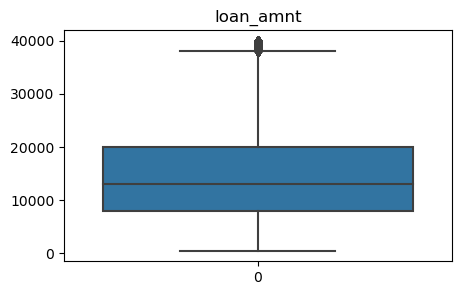

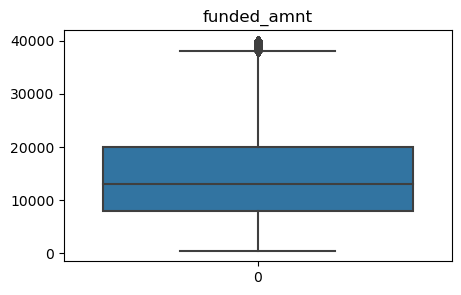

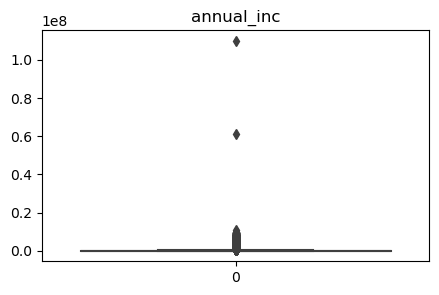

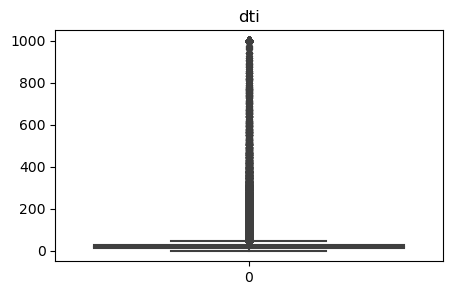

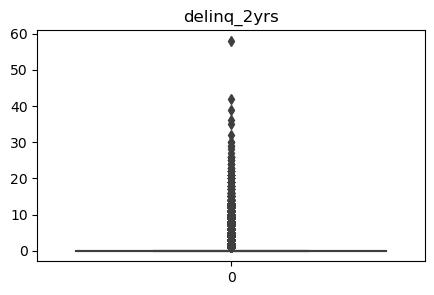

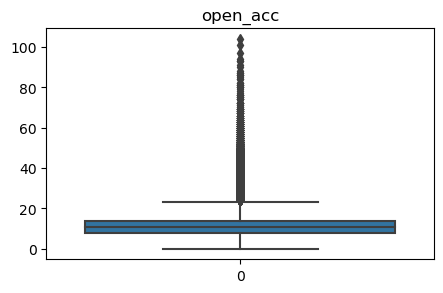

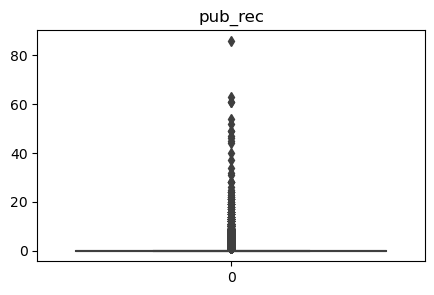

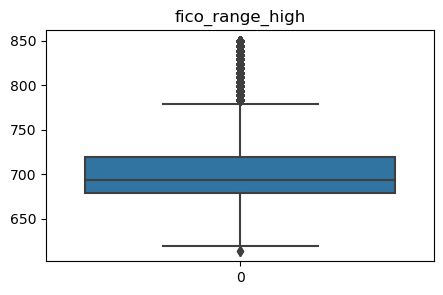

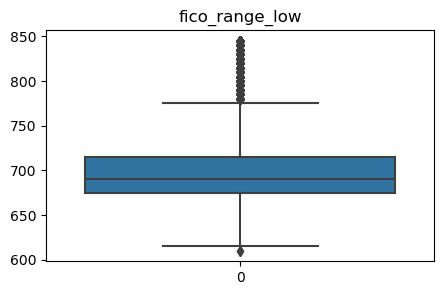

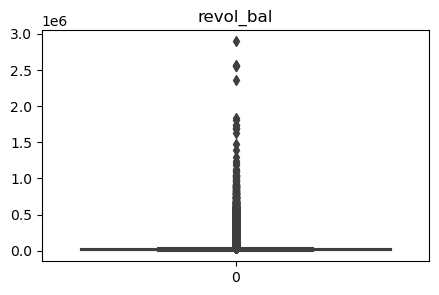

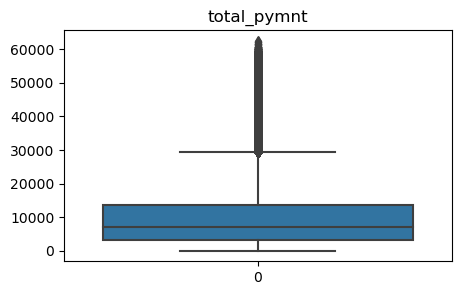

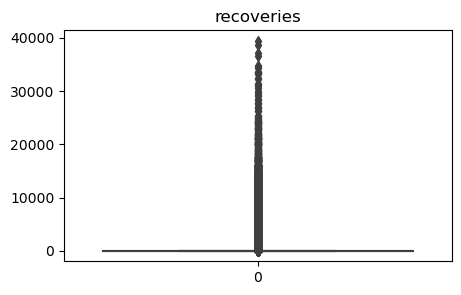

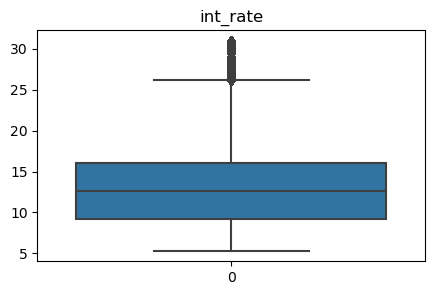

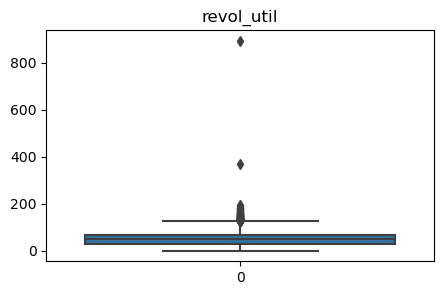

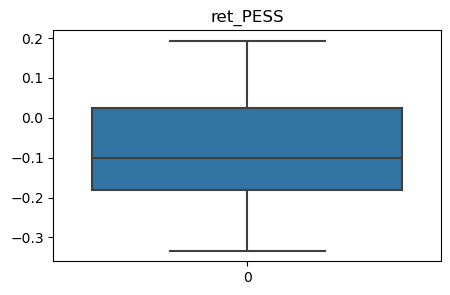

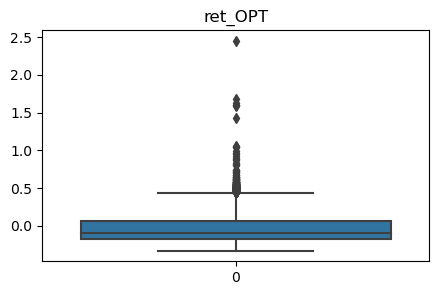

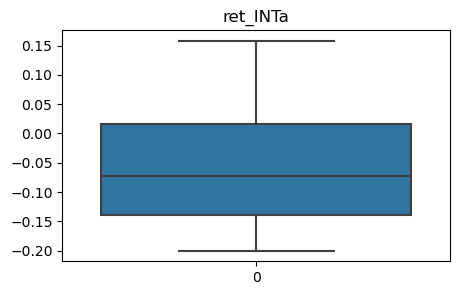

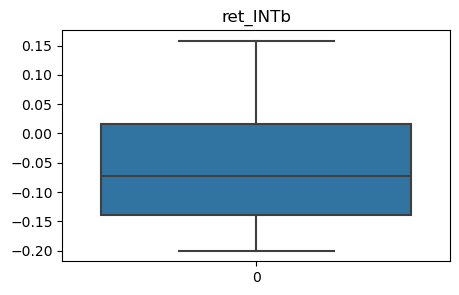

Field name: term
Number of distinct values in term: 2
 36 months: 1947319
 60 months: 814799


Field name: grade
Number of distinct values in grade: 7
B: 810672
C: 767781
A: 595897
D: 396411
E: 137921
F: 41450
G: 11986


Field name: emp_length
Number of distinct values in emp_length: 11
10+ years: 897562
< 1 year: 253308
2 years: 247089
3 years: 219473
1 year: 182798
5 years: 171573
4 years: 166329
6 years: 123540
7 years: 109983
8 years: 107362
9 years: 91342


Field name: home_ownership
Number of distinct values in home_ownership: 6
MORTGAGE: 1357826
RENT: 1089070
OWN: 311595
ANY: 3390
OTHER: 182
NONE: 55


Field name: verification_status
Number of distinct values in verification_status: 3
Source Verified: 1065494
Not Verified: 996591
Verified: 700033


Field name: loan_status
Number of distinct values in loan_status: 9
Current: 1559755
Fully Paid: 901142
Charged Off: 235079
Late (31-120 days): 33803
In Grace Period: 19614
Late (16-30 days): 9049
Does not meet the credit policy. Stat

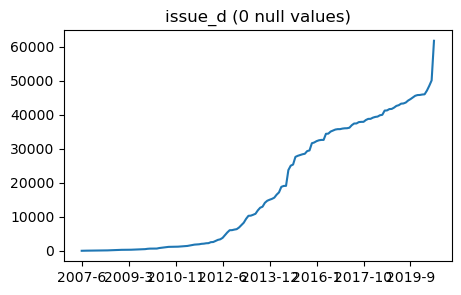

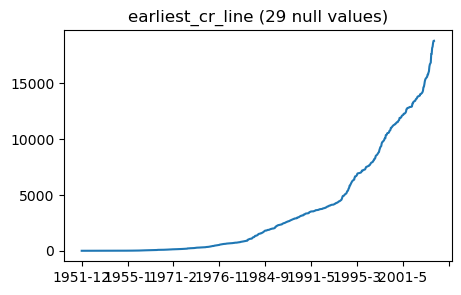

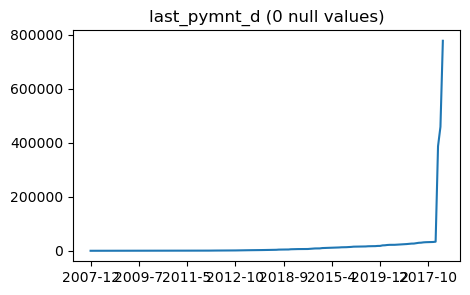

In [26]:
# visualize continuous features
visualize_float_columns()

# visulaize categorical features
visualize_cat_columns()

# visualize date columns
visualize_date_columns()


# modified at 17:18

### Handle outliers

In [27]:
# There are quite a few outliers.
# Please identify top-k (decide this based on the visualization) features where outliers are most obvious
final_data_copied = final_data.copy()

n_rows = len(final_data)

#final_data = final_data[final_data['annual_inc']<0.2] # remove outliers based 1st obvious feature
#final_data = final_data[final_data['annual_inc']<0.2] # remove outliers based 2nd obvious feature
#...
#final_data = ... # remove outliers based kth obvious feature

for var in float_cols:
  if var in ['dti','delinq_2yrs', 'pub_rec','revol_bal','recoveries']:
    continue
  Q1 = final_data[var].quantile(0.25)
  Q3 = final_data[var].quantile(0.75)

  IQR = Q3 - Q1

  low_lim = Q1 - (2.5 * IQR)
  upp_lim = Q3 + (2.5 * IQR)

  final_data = final_data[~((final_data[var] < low_lim) | (final_data[var] > upp_lim))]


print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 133741 rows


In [28]:
# Remove all loans that are still current
n_rows = len(final_data)

final_data = final_data[final_data['loan_status'] != 'Current']
#modified 5:40

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 1493399 rows


In [29]:
# Only include loans isssued since 2010
n_rows = len(final_data)

final_data = final_data[final_data['issue_d'] >= pd.Timestamp(year=2010, month=1, day=1)]
#modified 5:40

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 8087 rows


### Drop null values

In [30]:
# Deal with null values. We allow cateogrical variables to be null
# OTHER than grade, which is a particularly important categorical.
# All non-categorical variables must be non-null, and we drop
# rows that do not meet this requirement

required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(final_data)

final_data = final_data.dropna(subset=required_cols) # drop rows that contain null based only on "required_cols"
# modified 6:17

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 1459 rows


### Visualize clean data

In [31]:
# Visualize the data again after cleaning
# visualize continuous features
visualize_float_columns()

# visulaize categorical features
visualize_cat_columns()

# visualize date columns
visualize_date_columns()


# modified at 18:30

KeyError: 0

<Figure size 500x300 with 0 Axes>

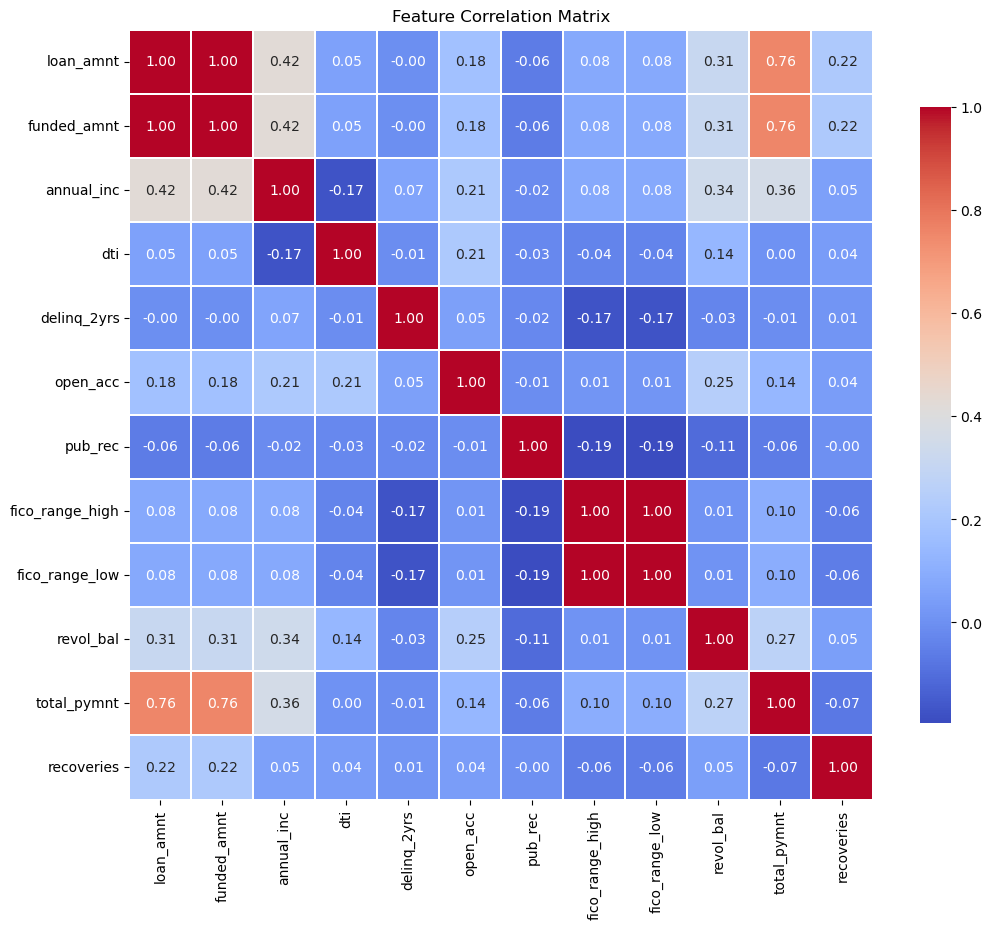

In [32]:
# Visualize the feature correlations
    # You can compute the correlation among features and display a heat-map of the matrix
    # OR use sns scatter or pairplot

import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr = final_data[float_cols].corr()

# Generate a heatmap
plt.figure(figsize=(12, 10))  # Adjust the size as needed
sns.heatmap(corr,
            annot=True,   # Annotate cells with correlation values
            cmap='coolwarm',  # Choose a color scheme
            fmt=".2f",  # Formatting the annotation to 2 decimal places
            linewidths=.05,  # Lines between cells
            cbar_kws={"shrink": .8}  # Adjust color bar size
           )

plt.title('Feature Correlation Matrix')
plt.show()

#modified 6:17

KeyboardInterrupt: 

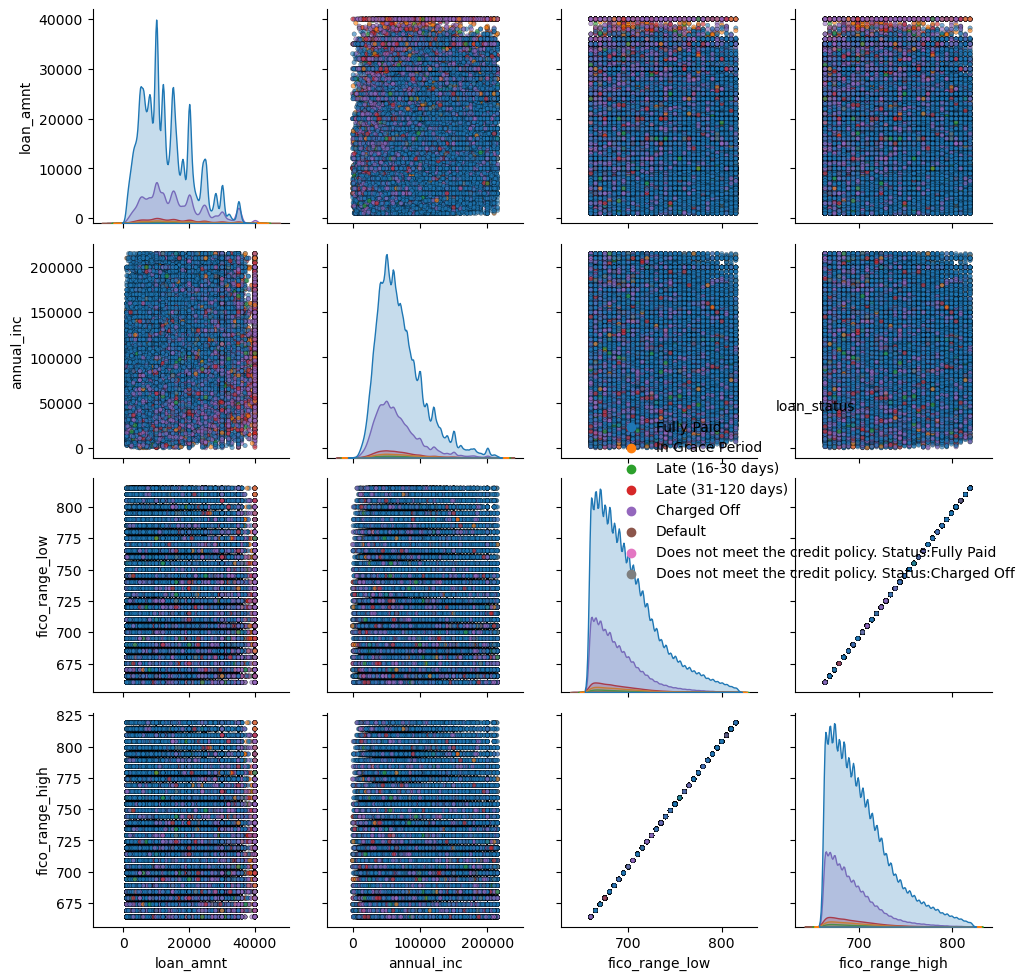

In [33]:
# Visualize relation between loan status and features
# sns pairplot or scatter plot. Refer to recitations

import seaborn as sns
import matplotlib.pyplot as plt

# Select a subset of features to avoid a cluttered plot. Include 'loan_status'.
features_subset = ['loan_amnt', 'annual_inc', 'fico_range_low', 'fico_range_high', 'loan_status']

# Use sns.pairplot on the subset

sns.pairplot(final_data[features_subset], 
             hue='loan_status', 
             diag_kind='kde', 
             plot_kws={'alpha':0.6, 's':10, 'edgecolor':'k'}, height=2.5)

plt.suptitle('Relationship Between Loan Status and Features', size=20, y=1.02)
plt.show()

#modified 6:17
#modified at Apr 9， 14:17

What do you observe after removing the outliers?

Answer:

Below observations can be gained after removing the outliers:

1. Loan Amount (loan_amnt): The distribution of loan amounts across different loan statuses suggests that fully paid status has the highest load amount, followed by Charged Off, Late (31-120 days), In Grace Period and Late (16-30 days).

2. Annual Income (annual_inc): Higher annual incomes seem to slightly correlate with a lower chance of default and a higher likelihood of full payment. The density is concentrated at the lower end of the income spectrum, which could imply that individuals with lower incomes are more likely to have varied loan statuses. However, default and late status still exist in any levels of Annual Income.

3. FICO Scores (fico_range_low and fico_range_high): There's a clear trend that higher FICO scores are associated with loans that are fully paid, while lower FICO scores are more common among loans that are in default or late. This is consistent with the expectation that credit scores are indicative of credit risk.

4. Density Plots: The distributions of fully paid loans tend to skew towards higher annual incomes and higher FICO scores. In contrast, defaults and late payments are more skewed towards lower FICO scores.

5. Scatter Plots: The scatter plots reveal clusters and possible correlations. There's a concentration of points in the lower range of loan amounts and incomes, which could imply that smaller loans are more common, regardless of the loan status. However, these plots also show that defaults are spread across the range of loan amounts and incomes, though less frequent at the higher end of the income range.

### Data Exploration
Solution to Q.7 from the handout

In [ ]:
# Find the percentage of loans by grade, the default by grade,
# and the return of each grade
perc_by_grade = (final_data.grade.value_counts()*100/len(final_data)).sort_index()

default_by_grade = final_data.groupby("grade").apply(lambda x : (x.loan_status != "Fully Paid").sum()*100/len(x) )
ret_by_grade_OPT = final_data.groupby('grade')['ret_OPT'].mean() # average return for M2-Optimistic for each loan grade
ret_by_grade_PESS = final_data.groupby('grade')['ret_PESS'].mean() # average return for M1-Pessimistic for each loan grade
ret_by_grade_INTa = final_data.groupby('grade')['ret_INTa'].mean() # average return for M3
ret_by_grade_INTb = final_data.groupby('grade')['ret_INTb'].mean() # average return for M3
int_rate_by_grade = final_data.groupby('grade')['int_rate'].mean() # average interest rate for each grade

combined = pd.DataFrame(perc_by_grade)
combined.columns = ['perc_of_loans']
combined['perc_default'] = default_by_grade
combined['avg_int_rate'] = int_rate_by_grade
combined['return_OPT'] = ret_by_grade_OPT
combined['return_PESS'] = ret_by_grade_PESS
combined['return_INTa'] = ret_by_grade_INTa
combined['return_INTb'] = ret_by_grade_INTb

combined

Based on the output of previous cell, write down your answers to Q.7 from the handout.

(i) What percentage of loans are in each grade?

Answer: Grade A takes around 20% of the loans. Grade B&C each takes around 30% of the loans. And grade D-G takes up the remaining 20% of the loans. This indicates that most of loans are from the top grades.

(ii) What is the default rate in each grade? How do you interpret those numbers?

Answer: The default rate is around 13% for grade A loans, 25% for grade B loans, and around 38% for grade C loans. It then increases to around 50% and higher for grade D-G loans.
This aligns with out expectations, where higher grade of loans have a lower default rate. As the grade of loans decreases, their default rates will increase, indicating a higher risk of lending.

(iii) What is the average interest rate in each grade? How do you interpret those
numbers?

Answer: The average interest rate is 7% for grade A, 10% for grade B, and 14% for grade C.
For grade D-G, it subsequently increases from around 20% to 30%. This indicates that the lower the grade of the loan, the higher the interest rate it has. The increase in the interest rate, however, is not as much as the increase of default rate.

(iv) What is the average percentage (annual) return per grade (as calculated using the
three methods in part 6.)? (Assume two different yearly rates for M3: (i = 1.4)
and (i = 2))
Answer:
The average percentage (annual) return per grade, as calculated using the three methods (optimistic, pessimistic, and two interpretations of the intermediate scenario), are as follows:

- Grade A: -0.00179%
- Grade B: -0.01335%
- Grade C: -0.02849%
- Grade D: -0.04067%
- Grade E: -0.04398%
- Grade F: -0.05564%
- Grade G: -0.06722%

(v) Do these numbers surprise you? If you had to invest in one grade only, which
loans would you invest in?

Answer: It's a bit surprising to know that the default rate of lower grade is much higher than high grade of loans, while the interest rate doesn't go up proportionally.
I would invest in grade A loans, because lower grade loans didn't provide a equally higher returns comparing to their increasing risks.

### Save a Pickle

In [34]:
# Remove the "total_pymnt" and "recoveries" from the list of continuous features
continuous_features = [feature for feature in continuous_features if feature not in ["total_pymnt", "recoveries"]]

Why did we remove `total_pymt` and `recoveries` from the data for the task of predicting whether to give loan or not, although these are highly predictive features?

Answer:

Because `total_pymt` and `recoveries` are features that can only be derived at the end of the load lifecycle. Introducing these features druing the task of predicting on the decision of giving a load could lead to data leakage, which means that information that can significantly affect the results but actually cannot be collected in real-world application would be involved during the training. This problem will drag down the model performance on real-world prediction.

In [35]:
# save the prepared data for modeling in next Phase.
pickle.dump( [final_data, discrete_features, continuous_features, ret_cols], open(pickle_file, "wb") )